In [1]:
# Import necessary libraries
import pulp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define the problem
prob = pulp.LpProblem("Furniture_Production_Optimization", pulp.LpMaximize)

# Define decision variables
# How many tables and chairs to produce
tables = pulp.LpVariable("Tables", lowBound=0, cat='Integer')
chairs = pulp.LpVariable("Chairs", lowBound=0, cat='Integer')

In [3]:
# Parameters
# Profit per unit
profit_table = 200  # dollars per table
profit_chair = 75   # dollars per chair

# Resource requirements
# Wood requirements (board feet)
wood_table = 30
wood_chair = 10

# Labor hours
labor_table = 5
labor_chair = 2

# Finishing hours
finish_table = 3
finish_chair = 1

# Resource constraints
total_wood = 600    # board feet available
total_labor = 120   # labor hours available
total_finish = 80   # finishing hours available

# Market constraints
min_tables = 5      # minimum tables to produce
max_chairs = 50     # maximum chairs market can absorb


In [4]:
# Define objective function (maximize profit)
prob += profit_table * tables + profit_chair * chairs, "Total_Profit"

# Add constraints
prob += wood_table * tables + wood_chair * chairs <= total_wood, "Wood_Constraint"
prob += labor_table * tables + labor_chair * chairs <= total_labor, "Labor_Constraint"
prob += finish_table * tables + finish_chair * chairs <= total_finish, "Finishing_Constraint"
prob += tables >= min_tables, "Minimum_Tables"
prob += chairs <= max_chairs, "Maximum_Chairs"

# Solve the problem
prob.solve()

# Print status
print(f"Status: {pulp.LpStatus[prob.status]}")

# Print results
print("\nOptimal Production Plan:")
print(f"Tables to produce: {tables.value()}")
print(f"Chairs to produce: {chairs.value()}")
print(f"Total profit: ${pulp.value(prob.objective)}")

# Resource utilization analysis
wood_used = wood_table * tables.value() + wood_chair * chairs.value()
labor_used = labor_table * tables.value() + labor_chair * chairs.value()
finish_used = finish_table * tables.value() + finish_chair * chairs.value()

print("\nResource Utilization:")
print(f"Wood: {wood_used}/{total_wood} board feet ({wood_used/total_wood*100:.1f}%)")
print(f"Labor: {labor_used}/{total_labor} hours ({labor_used/total_labor*100:.1f}%)")
print(f"Finishing: {finish_used}/{total_finish} hours ({finish_used/total_finish*100:.1f}%)")

Status: Optimal

Optimal Production Plan:
Tables to produce: 5.0
Chairs to produce: 45.0
Total profit: $4375.0

Resource Utilization:
Wood: 600.0/600 board feet (100.0%)
Labor: 115.0/120 hours (95.8%)
Finishing: 60.0/80 hours (75.0%)


In [5]:
# Identify binding constraints
print("\nBinding Constraints:")
for name, constraint in prob.constraints.items():
    slack = constraint.slack
    if abs(slack) < 1e-6:  # Effectively zero
        print(f"- {name}: This constraint is binding (slack: {slack})")
    else:
        print(f"- {name}: Not binding (slack: {slack})")


Binding Constraints:
- Wood_Constraint: This constraint is binding (slack: -0.0)
- Labor_Constraint: Not binding (slack: 5.0)
- Finishing_Constraint: Not binding (slack: 20.0)
- Minimum_Tables: This constraint is binding (slack: -0.0)
- Maximum_Chairs: Not binding (slack: 5.0)


In [6]:
# Sensitivity analysis
print("\nShadow Prices (value of one more unit of resource):")
for name, constraint in prob.constraints.items():
    if hasattr(constraint, 'pi'):
        print(f"- {name}: ${constraint.pi}")

# Visualize results
resources = ['Wood', 'Labor', 'Finishing']
available = [total_wood, total_labor, total_finish]
used = [wood_used, labor_used, finish_used]


Shadow Prices (value of one more unit of resource):
- Wood_Constraint: $-0.0
- Labor_Constraint: $-0.0
- Finishing_Constraint: $-0.0
- Minimum_Tables: $-0.0
- Maximum_Chairs: $-0.0


C:\Users\ay569\AppData\Local\Temp\ipykernel_27084\205726282.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Resource', y='Utilization %', data=df, palette='viridis')


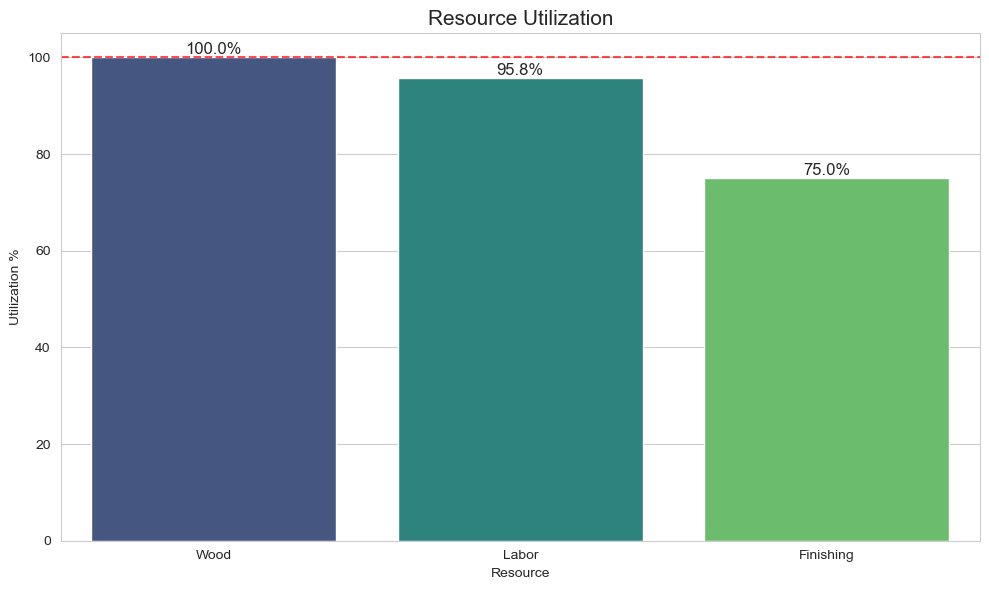

In [7]:
# Create DataFrame for visualization
df = pd.DataFrame({
    'Resource': resources,
    'Available': available,
    'Used': used,
    'Utilization %': [u/a*100 for u, a in zip(used, available)]
})

# Plot resource utilization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='Resource', y='Utilization %', data=df, palette='viridis')
plt.title('Resource Utilization', fontsize=15)
plt.ylabel('Utilization %')
plt.axhline(y=100, color='red', linestyle='--', alpha=0.7)

for i, p in enumerate(ax.patches):
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=12)

plt.tight_layout()
plt.show()

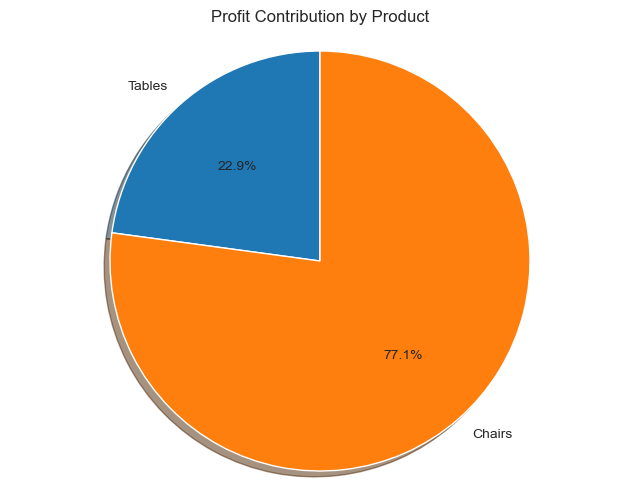

In [8]:
# Profit contribution visualization
products = ['Tables', 'Chairs']
quantities = [tables.value(), chairs.value()]
profits = [profit_table * tables.value(), profit_chair * chairs.value()]

plt.figure(figsize=(8, 6))
plt.pie(profits, labels=products, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Profit Contribution by Product')
plt.axis('equal')
plt.show()

# What-if analysis: How would profit change with more wood?
what_if_results = []
wood_range = range(total_wood, total_wood + 201, 20)

for wood in wood_range:
    # Create a new problem for each scenario
    temp_prob = pulp.LpProblem("Temp", pulp.LpMaximize)
    temp_prob += profit_table * tables + profit_chair * chairs, "Total_Profit"
    temp_prob += wood_table * tables + wood_chair * chairs <= wood, "Wood_Constraint"
    temp_prob += labor_table * tables + labor_chair * chairs <= total_labor, "Labor_Constraint"
    temp_prob += finish_table * tables + finish_chair * chairs <= total_finish, "Finishing_Constraint"
    temp_prob += tables >= min_tables, "Minimum_Tables"
    temp_prob += chairs <= max_chairs, "Maximum_Chairs"
    
    temp_prob.solve()
    what_if_results.append((wood, pulp.value(temp_prob.objective)))


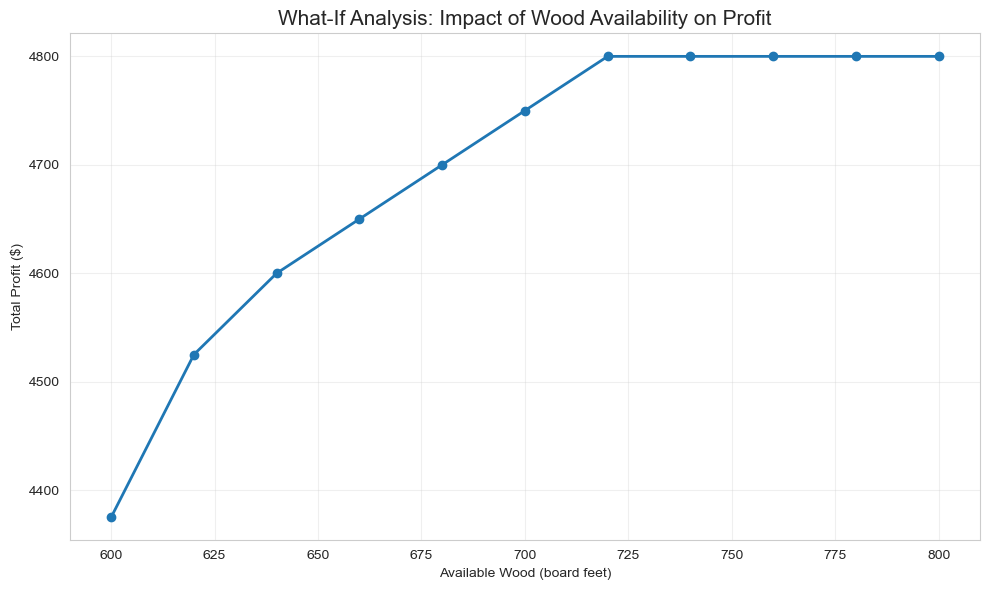


Business Insights:
1. The optimal production mix maximizes profit while respecting all constraints.
2. The company should produce 24 tables and 0 chairs.
3. This will generate a total profit of $4800.00.
4. Resource utilization analysis shows which resources are limiting production.
5. The shadow prices indicate which resources would be most valuable to increase.


In [10]:
# Plot what-if analysis
plt.figure(figsize=(10, 6))
wood_values = [x[0] for x in what_if_results]
profit_values = [x[1] for x in what_if_results]
plt.plot(wood_values, profit_values, marker='o', linestyle='-', linewidth=2)
plt.title('What-If Analysis: Impact of Wood Availability on Profit', fontsize=15)
plt.xlabel('Available Wood (board feet)')
plt.ylabel('Total Profit ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print business insights
print("\nBusiness Insights:")
print("1. The optimal production mix maximizes profit while respecting all constraints.")
print(f"2. The company should produce {int(tables.value())} tables and {int(chairs.value())} chairs.")
print(f"3. This will generate a total profit of ${pulp.value(prob.objective):.2f}.")
print("4. Resource utilization analysis shows which resources are limiting production.")
print("5. The shadow prices indicate which resources would be most valuable to increase.")